In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from datetime import datetime

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
train_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv")
test_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv")
oil_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv")
stores_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")

In [3]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
test_df.sample(15)

,id,date,store_nbr,family,onpromotion
20105,3020993,2017-08-27,23,DAIRY,10
28114,3029002,2017-08-31,47,SCHOOL AND OFFICE SUPPLIES,13
7458,3008346,2017-08-20,19,AUTOMOTIVE,0
14331,3015219,2017-08-24,11,DELI,10
5622,3006510,2017-08-19,17,GROCERY I,55
16040,3016928,2017-08-25,1,BEAUTY,0
25410,3026298,2017-08-30,22,AUTOMOTIVE,0
18515,3019403,2017-08-26,29,BEAUTY,0
27393,3028281,2017-08-31,28,BEVERAGES,26
26925,3027813,2017-08-31,14,PRODUCE,2


In [5]:
duplicates = train_df[train_df.duplicated(subset=['date', 'store_nbr', "family"], keep=False)]
duplicates

,id,date,store_nbr,family,sales,onpromotion


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [7]:
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [8]:
oil_df["date"]=pd.to_datetime(oil_df["date"])

In [9]:
train_df["date"] = pd.to_datetime(train_df["date"])

In [10]:
train_df.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [11]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [12]:
correlation_with_prom = train_df["onpromotion"].corr(train_df["sales"])
correlation_with_prom

0.4279232048121313

In [13]:
correlation_with_oil = oil_df["dcoilwtico"].corr(train_df["sales"])
correlation_with_oil
#too low to use this feature in model

-0.049346765971872424

In [14]:
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [15]:
train_df = train_df.merge(stores_df, on="store_nbr", how="left").drop("id", axis=1)
test_df = test_df.merge(stores_df, on="store_nbr", how="left").drop("id", axis=1)

In [16]:
train_df.sample(10)

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
2759265,2017-04-02,3,BEVERAGES,13586.000,10,Quito,Pichincha,D,8
1842330,2015-11-02,51,CELEBRATION,10.000,0,Guayaquil,Guayas,A,17
559697,2013-11-11,13,HOME APPLIANCES,0.000,0,Latacunga,Cotopaxi,C,15
1318917,2015-01-13,16,CELEBRATION,0.000,0,Santo Domingo,Santo Domingo de los Tsachilas,C,3
951737,2014-06-20,13,HOME APPLIANCES,0.000,0,Latacunga,Cotopaxi,C,15
165159,2013-04-03,42,PLAYERS AND ELECTRONICS,0.000,0,Cuenca,Azuay,D,2
1017904,2014-07-27,2,LADIESWEAR,66.000,0,Quito,Pichincha,D,13
757143,2014-03-02,52,MEATS,0.000,0,Manta,Manabi,A,11
973506,2014-07-02,24,CELEBRATION,0.000,0,Guayaquil,Guayas,D,1
2743563,2017-03-24,39,DELI,197.159,52,Cuenca,Azuay,B,6


In [17]:
avg_sales_by_city= train_df.groupby("city")["sales"].mean().sort_values().reset_index()
avg_sales_by_city

,city,sales
0,Puyo,73.601845
1,Manta,125.173982
2,Playas,138.139340
3,Latacunga,190.583961
4,El Carmen,198.975799
5,Riobamba,204.921881
6,Salinas,205.517129
7,Ibarra,206.061866
8,Santo Domingo,214.942315
9,Guaranda,234.821670


Text(0, 0.5, 'Average sales')

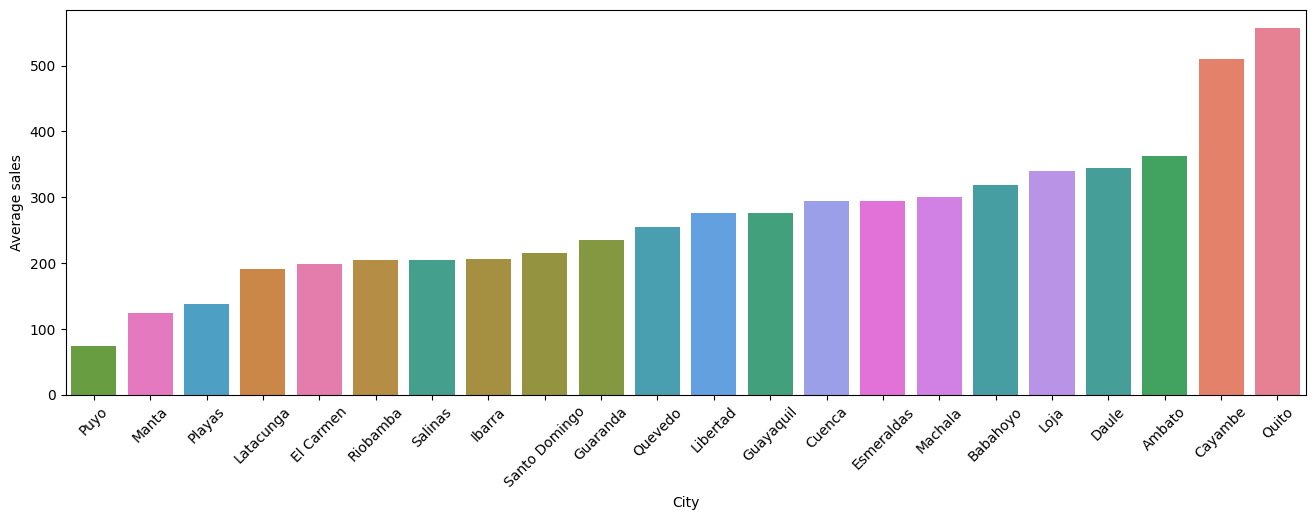

In [18]:
unique_cities = train_df['city'].unique()
color_palette = dict(zip(unique_cities, sns.color_palette("husl", n_colors=len(unique_cities))))
plt.figure(figsize=(16,5))
sns.barplot(x="city", y="sales", data=avg_sales_by_city, palette=color_palette)
plt.xticks(rotation=45)
plt.xlabel("City")
plt.ylabel("Average sales")



In [19]:
sorted_stores = train_df.groupby('store_nbr')['sales'].mean().sort_values().index
store_to_city = train_df.groupby('store_nbr')['city'].first()
store_colors = [color_palette[store_to_city[store]] for store in sorted_stores]

Text(0, 0.5, 'Average sales')

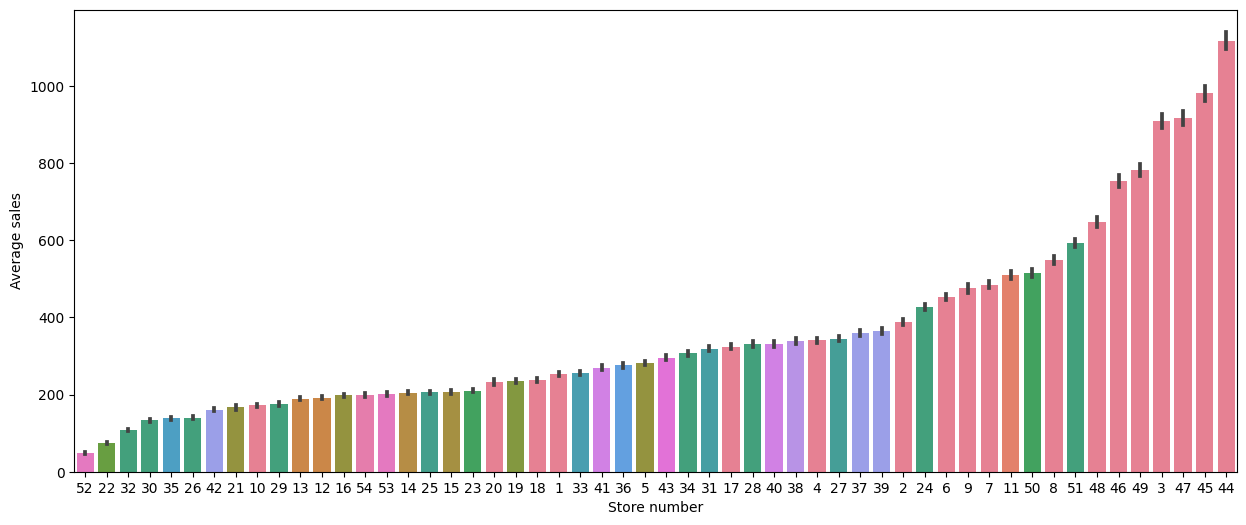

In [20]:
plt.figure(figsize=(15,6))
sns.barplot(data=train_df, x="store_nbr", y="sales", order=sorted_stores, palette=store_colors)
plt.xlabel("Store number")
plt.ylabel("Average sales")
#there's a clear connection between sales number and city where the store is located, but using only the store number is likely giving 
#a better result if its broken down into fewer categories based on sales volume, because of the individual differences in a city


In [50]:
train_df.groupby('store_nbr')['sales'].mean().sort_values()

store_nbr
52      48.516694
22      73.601845
32     107.100626
30     132.838006
35     138.139340
26     139.550887
42     160.976173
21     166.549808
10     172.999096
29     175.001038
13     189.358775
12     191.809148
16     197.696908
54     198.975799
53     201.831269
14     204.921881
25     205.517129
15     206.061866
23     209.662792
20     232.508360
19     234.821670
18     238.598137
1      254.534889
33     255.137503
41     269.758856
36     275.722146
5      280.580231
43     294.963151
34     307.542182
31     319.349181
17     324.461406
28     330.798871
40     331.025650
38     339.379530
4      340.273886
27     345.282181
37     359.365069
39     364.431594
2      387.918172
24     427.692592
6      453.172101
9      475.229271
7      484.993334
11     509.709179
50     515.601753
8      548.734739
51     592.231511
48     646.604950
46     753.905962
49     781.330450
3      908.405495
47     916.798209
45     980.673908
44    1117.245254
Name: sales, dtype

In [21]:
train_df.head()

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13
2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13
3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13
4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13


<Axes: xlabel='family', ylabel='sales'>

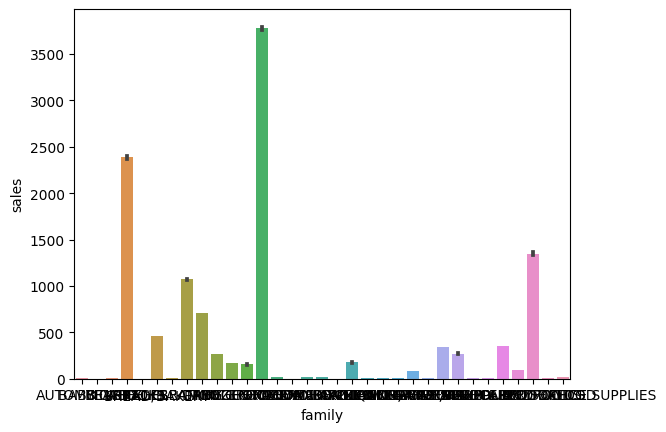

In [22]:
sns.barplot(data=train_df, x="family", y="sales")

In [23]:
avg_sales_by_family= train_df.groupby("family")["sales"].mean().sort_values().reset_index()
avg_sales_by_family

,family,sales
0,BOOKS,0.070797
1,BABY CARE,0.110528
2,HOME APPLIANCES,0.457476
3,HARDWARE,1.137833
4,MAGAZINES,2.929082
5,SCHOOL AND OFFICE SUPPLIES,2.961599
6,BEAUTY,3.715723
7,PET SUPPLIES,3.921263
8,LAWN AND GARDEN,6.035475
9,AUTOMOTIVE,6.101236


In [25]:
bins = [0, 5, 10, 80, 100, 200, 500, 1100, 1400, 2400, 3800]
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
avg_sales_by_family['family_cat'] = pd.cut(avg_sales_by_family['sales'], bins=bins, labels=labels, include_lowest=True)

In [26]:
avg_sales_by_family

,family,sales,family_cat
0,BOOKS,0.070797,0
1,BABY CARE,0.110528,0
2,HOME APPLIANCES,0.457476,0
3,HARDWARE,1.137833,0
4,MAGAZINES,2.929082,0
5,SCHOOL AND OFFICE SUPPLIES,2.961599,0
6,BEAUTY,3.715723,0
7,PET SUPPLIES,3.921263,0
8,LAWN AND GARDEN,6.035475,1
9,AUTOMOTIVE,6.101236,1


In [27]:
family_cat_dict = dict(zip(avg_sales_by_family['family'], avg_sales_by_family['family_cat']))
train_df["family"] = train_df['family'].map(family_cat_dict)

In [28]:
train_df.sample(15)

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
2908670,2017-06-25,21,0,0.00000,0,Santo Domingo,Santo Domingo de los Tsachilas,B,6
2532825,2016-11-25,26,5,120.60300,42,Guayaquil,Guayas,D,10
1730220,2015-08-31,6,7,2557.78900,0,Quito,Pichincha,D,13
201097,2013-04-23,50,5,253.90000,0,Ambato,Tungurahua,A,14
981572,2014-07-06,5,1,1.00000,0,Santo Domingo,Santo Domingo de los Tsachilas,D,4
1691492,2015-08-10,2,4,115.00000,1,Quito,Pichincha,D,13
1166653,2014-10-18,43,0,0.00000,0,Esmeraldas,Esmeraldas,E,10
695503,2014-01-27,23,5,252.96901,0,Ambato,Tungurahua,D,9
2500671,2016-11-07,23,7,1593.58900,0,Ambato,Tungurahua,D,9
309099,2013-06-23,31,1,7.00000,0,Babahoyo,Los Rios,B,10


In [44]:
def create_features(df_):
    df = df_.copy()
    
    df["month"] = df.date.dt.month
    df["year"] = df.date.dt.year
    df["quarter"] = df.date.dt.quarter
    df['dayofweek'] = df.date.dt.dayofweek
    
    return df

In [47]:
train_df_ = create_features(train_df)

In [48]:
train_df_.head()

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,month,year,quarter,dayofweek
0,2013-01-01,1,1,0.0,0,Quito,Pichincha,D,13,1,2013,1,1
1,2013-01-01,1,0,0.0,0,Quito,Pichincha,D,13,1,2013,1,1
2,2013-01-01,1,0,0.0,0,Quito,Pichincha,D,13,1,2013,1,1
3,2013-01-01,1,8,0.0,0,Quito,Pichincha,D,13,1,2013,1,1
4,2013-01-01,1,0,0.0,0,Quito,Pichincha,D,13,1,2013,1,1
